In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(digest)
library(infer)
library(cowplot)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Building a Model to Predict the Quality of Red Wine**

Trushaan Bundhoo, Jennifer Chu, Mantra Patel, Maira Zaidi

**Introduction**

Winemaking is a large global industry, with over 330 billion USD worth of wine sold in 2020. Cheap wine is around 15 USD / bottle, with more expensive ones fetching 500 USD+. Wine price is dictated partly by its quality, which is linked to factors like sugar content, acidity, alcohol content, and more. We would like to ask: can we predict the quality of a wine based on some of its intrinsic qualities? If so, which ones make the best predictors of overall quality. We begin by reading in a dataset about red wines.

In [2]:
#reading the data
red<- read_csv2("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv") 
red

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.997,326,0.65,98,5
112,0.28,0.56,19,0.075,17,60,0.998,316,0.58,98,6
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.66,0,18,0.075,13,40,0.9978,351,0.56,94,5
79,0.6,0.06,16,0.069,15,59,0.9964,33,0.46,94,5
73,0.65,0,12,0.065,15,21,0.9946,339,0.47,10,7
78,0.58,0.02,2,0.073,9,18,0.9968,336,0.57,95,7


**Preliminatory Data Analysis**

With the data set loaded in, we see the many variables measured in each wine, as well as the quality rating of each wine. To start off our analysis, we will perform a 75/25 training split, and set the quality column as a factor. since the ratings are integers, they can represent distinct categories, and setting the column as a factor is neccessary for a classification analysis.

In [3]:
#mutating 'quality' to factor variable since it represents categories
red_data <- red |>
            mutate(quality = as.factor(quality)) 
#making syntatically valid column names
colnames(red_data) <- make.names(colnames(red_data))


#creating training & testing set and making sure all varaibles are numeric values except quality variable
red_split<-initial_split(red_data, prop=0.75, strata=quality)
red_train<-training(red_split) |> mutate(chlorides =as.numeric(chlorides)) |> mutate(sulphates=as.numeric(sulphates)) |> mutate(volatile.acidity=as.numeric(volatile.acidity)) |> 
mutate(density=as.numeric(density)) |> mutate(citric.acid = as.numeric(citric.acid))

red_test<-testing(red_split) |> mutate(chlorides =as.numeric(chlorides)) |> mutate(sulphates=as.numeric(sulphates)) |> mutate(volatile.acidity=as.numeric(volatile.acidity)) |> 
mutate(density=as.numeric(density)) |> mutate(citric.acid = as.numeric(citric.acid))


red_train_set<-red_train
red_test_set<-red_test 
red_train




fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.700,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.880,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.760,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
74,0.700,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.660,0.00,18,0.075,13,40,0.9978,351,0.56,94,5
79,0.600,0.06,16,0.069,15,59,0.9964,33,0.46,94,5
75,0.500,0.36,61,0.071,17,102,0.9978,335,0.80,105,5
67,0.580,0.08,18,0.097,15,65,0.9959,328,0.54,92,5
78,0.610,0.29,16,0.114,9,29,0.9974,326,1.56,91,5


With our training andd testing sets made, we will now set our testing set aside. To aid in picking the best variables for our analysis, we will create a correlation matrix to find show which variables are most closely correlated with quality. We will convert all variables in our training set into the numerical type and call the "cor" function to create the correlation matrix.


In [4]:
#finding out correlation between variables to select the variables that have the highest correlation with quality 
red_data2 <- red_train |> mutate(citric.acid=as.numeric(citric.acid)) |>mutate(volatile.acidity=as.numeric(volatile.acidity)) |>
mutate(chlorides=as.numeric(chlorides)) |>mutate(density=as.numeric(density)) |>mutate(sulphates=as.numeric(sulphates)) |> mutate(quality=as.numeric(quality))
res <- cor(red_data2)
round(res, 2)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
fixed.acidity,1.00,-0.12,0.38,0.07,0.09,-0.05,NA,0.38,-0.07,0.15,0.00,0.08
volatile.acidity,-0.12,1.00,-0.55,0.04,0.08,-0.07,NA,0.03,-0.01,-0.25,0.06,-0.39
citric.acid,0.38,-0.55,1.00,0.08,0.20,0.04,NA,0.35,-0.08,0.30,-0.01,0.23
residual.sugar,0.07,0.04,0.08,1.00,0.01,0.05,NA,0.11,0.02,-0.03,0.02,0.00
chlorides,0.09,0.08,0.20,0.01,1.00,-0.01,NA,0.20,-0.08,0.39,0.00,-0.12
free.sulfur.dioxide,-0.05,-0.07,0.04,0.05,-0.01,1.00,NA,-0.11,-0.02,0.00,0.00,0.03
total.sulfur.dioxide,NA,NA,NA,NA,NA,NA,1,NA,NA,NA,NA,NA
density,0.38,0.03,0.35,0.11,0.20,-0.11,NA,1.00,-0.04,0.15,0.02,-0.16
pH,-0.07,-0.01,-0.08,0.02,-0.08,-0.02,NA,-0.04,1.00,-0.04,0.02,0.05
sulphates,0.15,-0.25,0.30,-0.03,0.39,0.00,NA,0.15,-0.04,1.00,-0.01,0.25


Looking under the quality column, the variables with the strongest correlations to quality are: volatile acidity, sulphates, citric acid, and density. While the correlation values point us in the right direction as to what predictors we should pick, they do not tell the whole story. To help us make a decisions about these predictors, we will create summary tables showing the mean values for each of these variables for a given quality rating

Moving on, we will now group the wines by quality and create a summary table to show the amount of wines with each quality rating.

In [5]:

#number of wines of each quality
counts<-red_train_set |>
        group_by(quality) |>
        summarize(n=n())
knitr::kable(counts, caption = "1: Counts of Wines with Each Quality Rating")

#mean volatile acidity of each quality
counts_volatile_acidity<-red_train |>
                        group_by(quality) |>
                        summarize(mean_volatile_acidity=mean(volatile.acidity)) 
knitr::kable(counts_volatile_acidity, caption = "2: Mean Volatile Acidity for Each Quality Rating")
#mean sulphate content of each quality
counts_sulphate<-red_train |>
                        group_by(quality) |>
                        summarize(mean_sulphate_content=mean(sulphates))
knitr::kable(counts_sulphate, caption = "3: Mean Sulphate Content for Each Quality Rating")
counts_density<-red_train |>
                        group_by(quality) |>
                        summarize(mean_density=mean(density))
knitr::kable(counts_density, caption = "4: Mean Density for Each Quality Rating")

counts_citric.acid<-red_train |>
                        group_by(quality) |>
                        summarize(mean_citric_acid=mean(citric.acid))
knitr::kable(counts_citric.acid, caption = "5: Mean Citric Acid Content for Each Quality Rating")



Table: 1: Counts of Wines with Each Quality Rating

|quality |   n|
|:-------|---:|
|3       |   7|
|4       |  44|
|5       | 507|
|6       | 473|
|7       | 149|
|8       |  17|



Table: 2: Mean Volatile Acidity for Each Quality Rating

|quality | mean_volatile_acidity|
|:-------|---------------------:|
|3       |             0.9850000|
|4       |             0.7055682|
|5       |             0.5744576|
|6       |             0.4992178|
|7       |             0.4064430|
|8       |             0.4300000|



Table: 3: Mean Sulphate Content for Each Quality Rating

|quality | mean_sulphate_content|
|:-------|---------------------:|
|3       |             0.5528571|
|4       |             0.6113636|
|5       |             0.6161736|
|6       |             0.6748626|
|7       |             0.7351678|
|8       |             0.7647059|



Table: 4: Mean Density for Each Quality Rating

|quality | mean_density|
|:-------|------------:|
|3       |    0.9969200|
|4       |    0.9965861|
|5       |    0.9970417|
|6       |    0.9965554|
|7       |    0.9962223|
|8       |    0.9950071|



Table: 5: Mean Citric Acid Content for Each Quality Rating

|quality | mean_citric_acid|
|:-------|----------------:|
|3       |        0.0771429|
|4       |        0.1772727|
|5       |        0.2450493|
|6       |        0.2746934|
|7       |        0.3695973|
|8       |        0.3717647|

The two tables generated from our training set provide insight about the wrangled data. Table 1 provides the number of red wines that were given a particular rating, with most being rated a 5/8. Table 2 provides the mean volatile acidity value for each rating, and we see that as wine quality goes up, the mean volatile acidity goes down, which agrees with the correlation value of -0.39 from the correlation matrix generated earlier. With some insights in hand, we will now generate some plots to help visualize the relationships between our predictors and the wine quality. Table 3 shows that the average sulphate content of a wine increases as its quality goes up. 


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



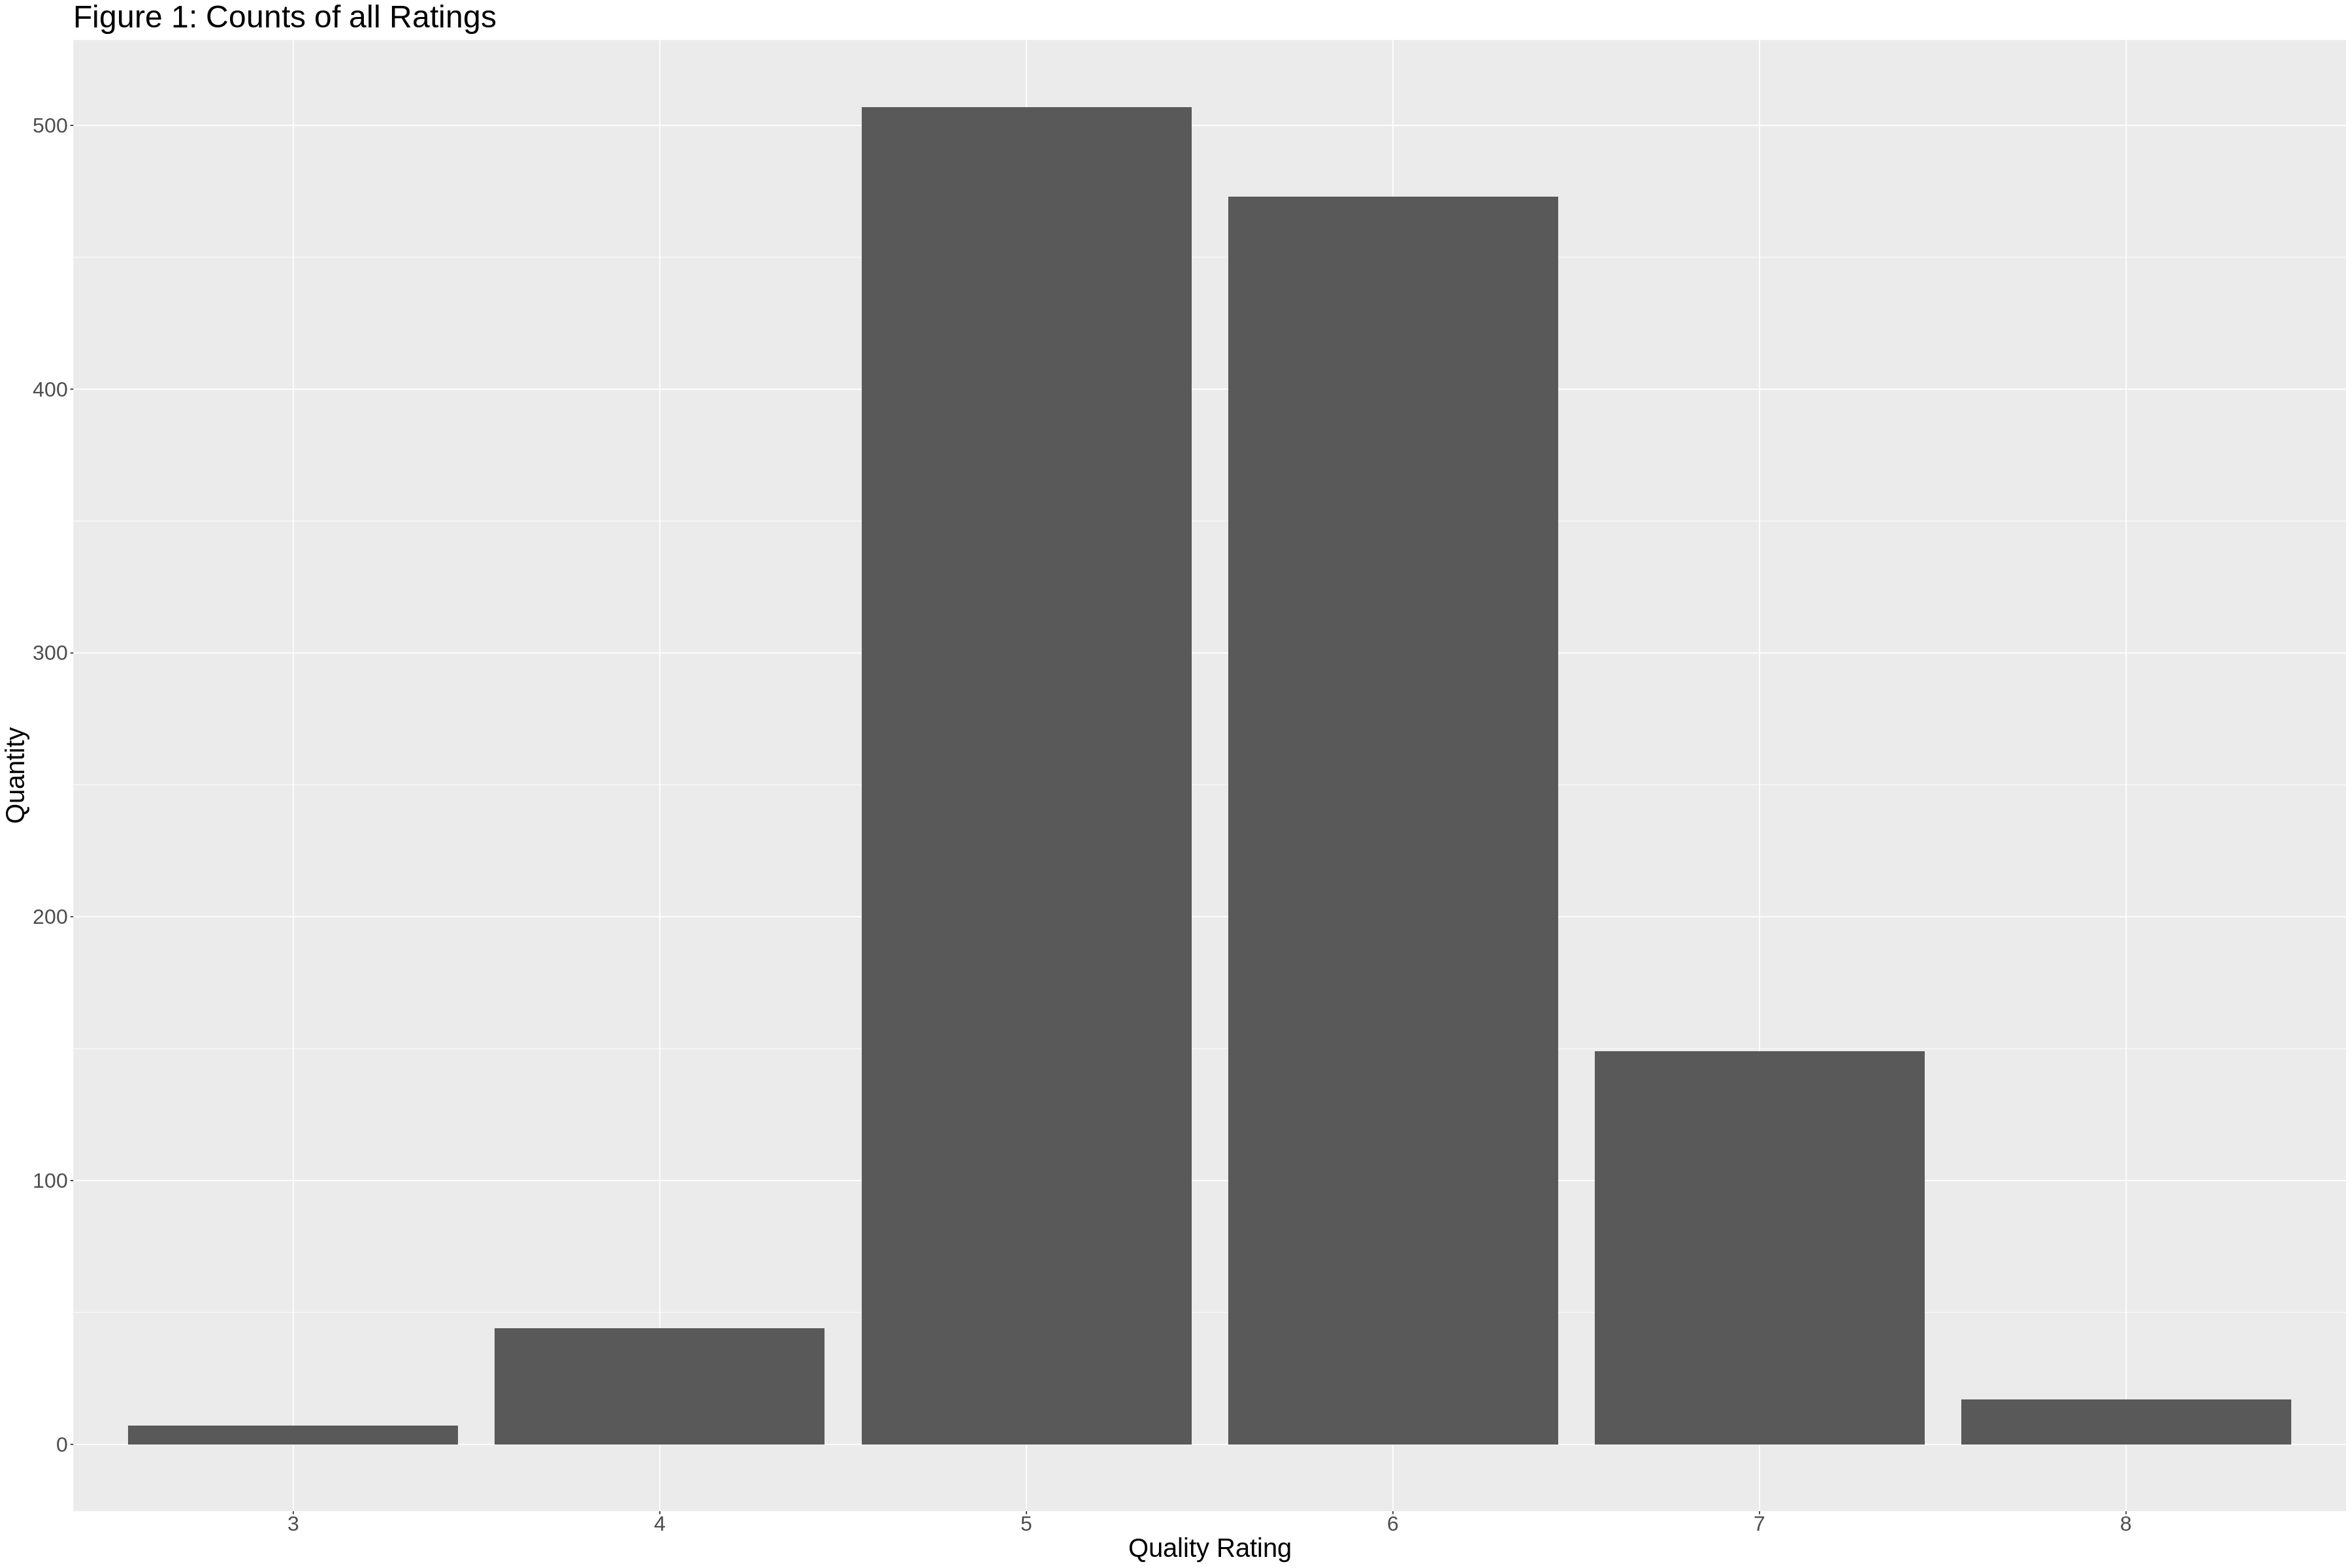

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



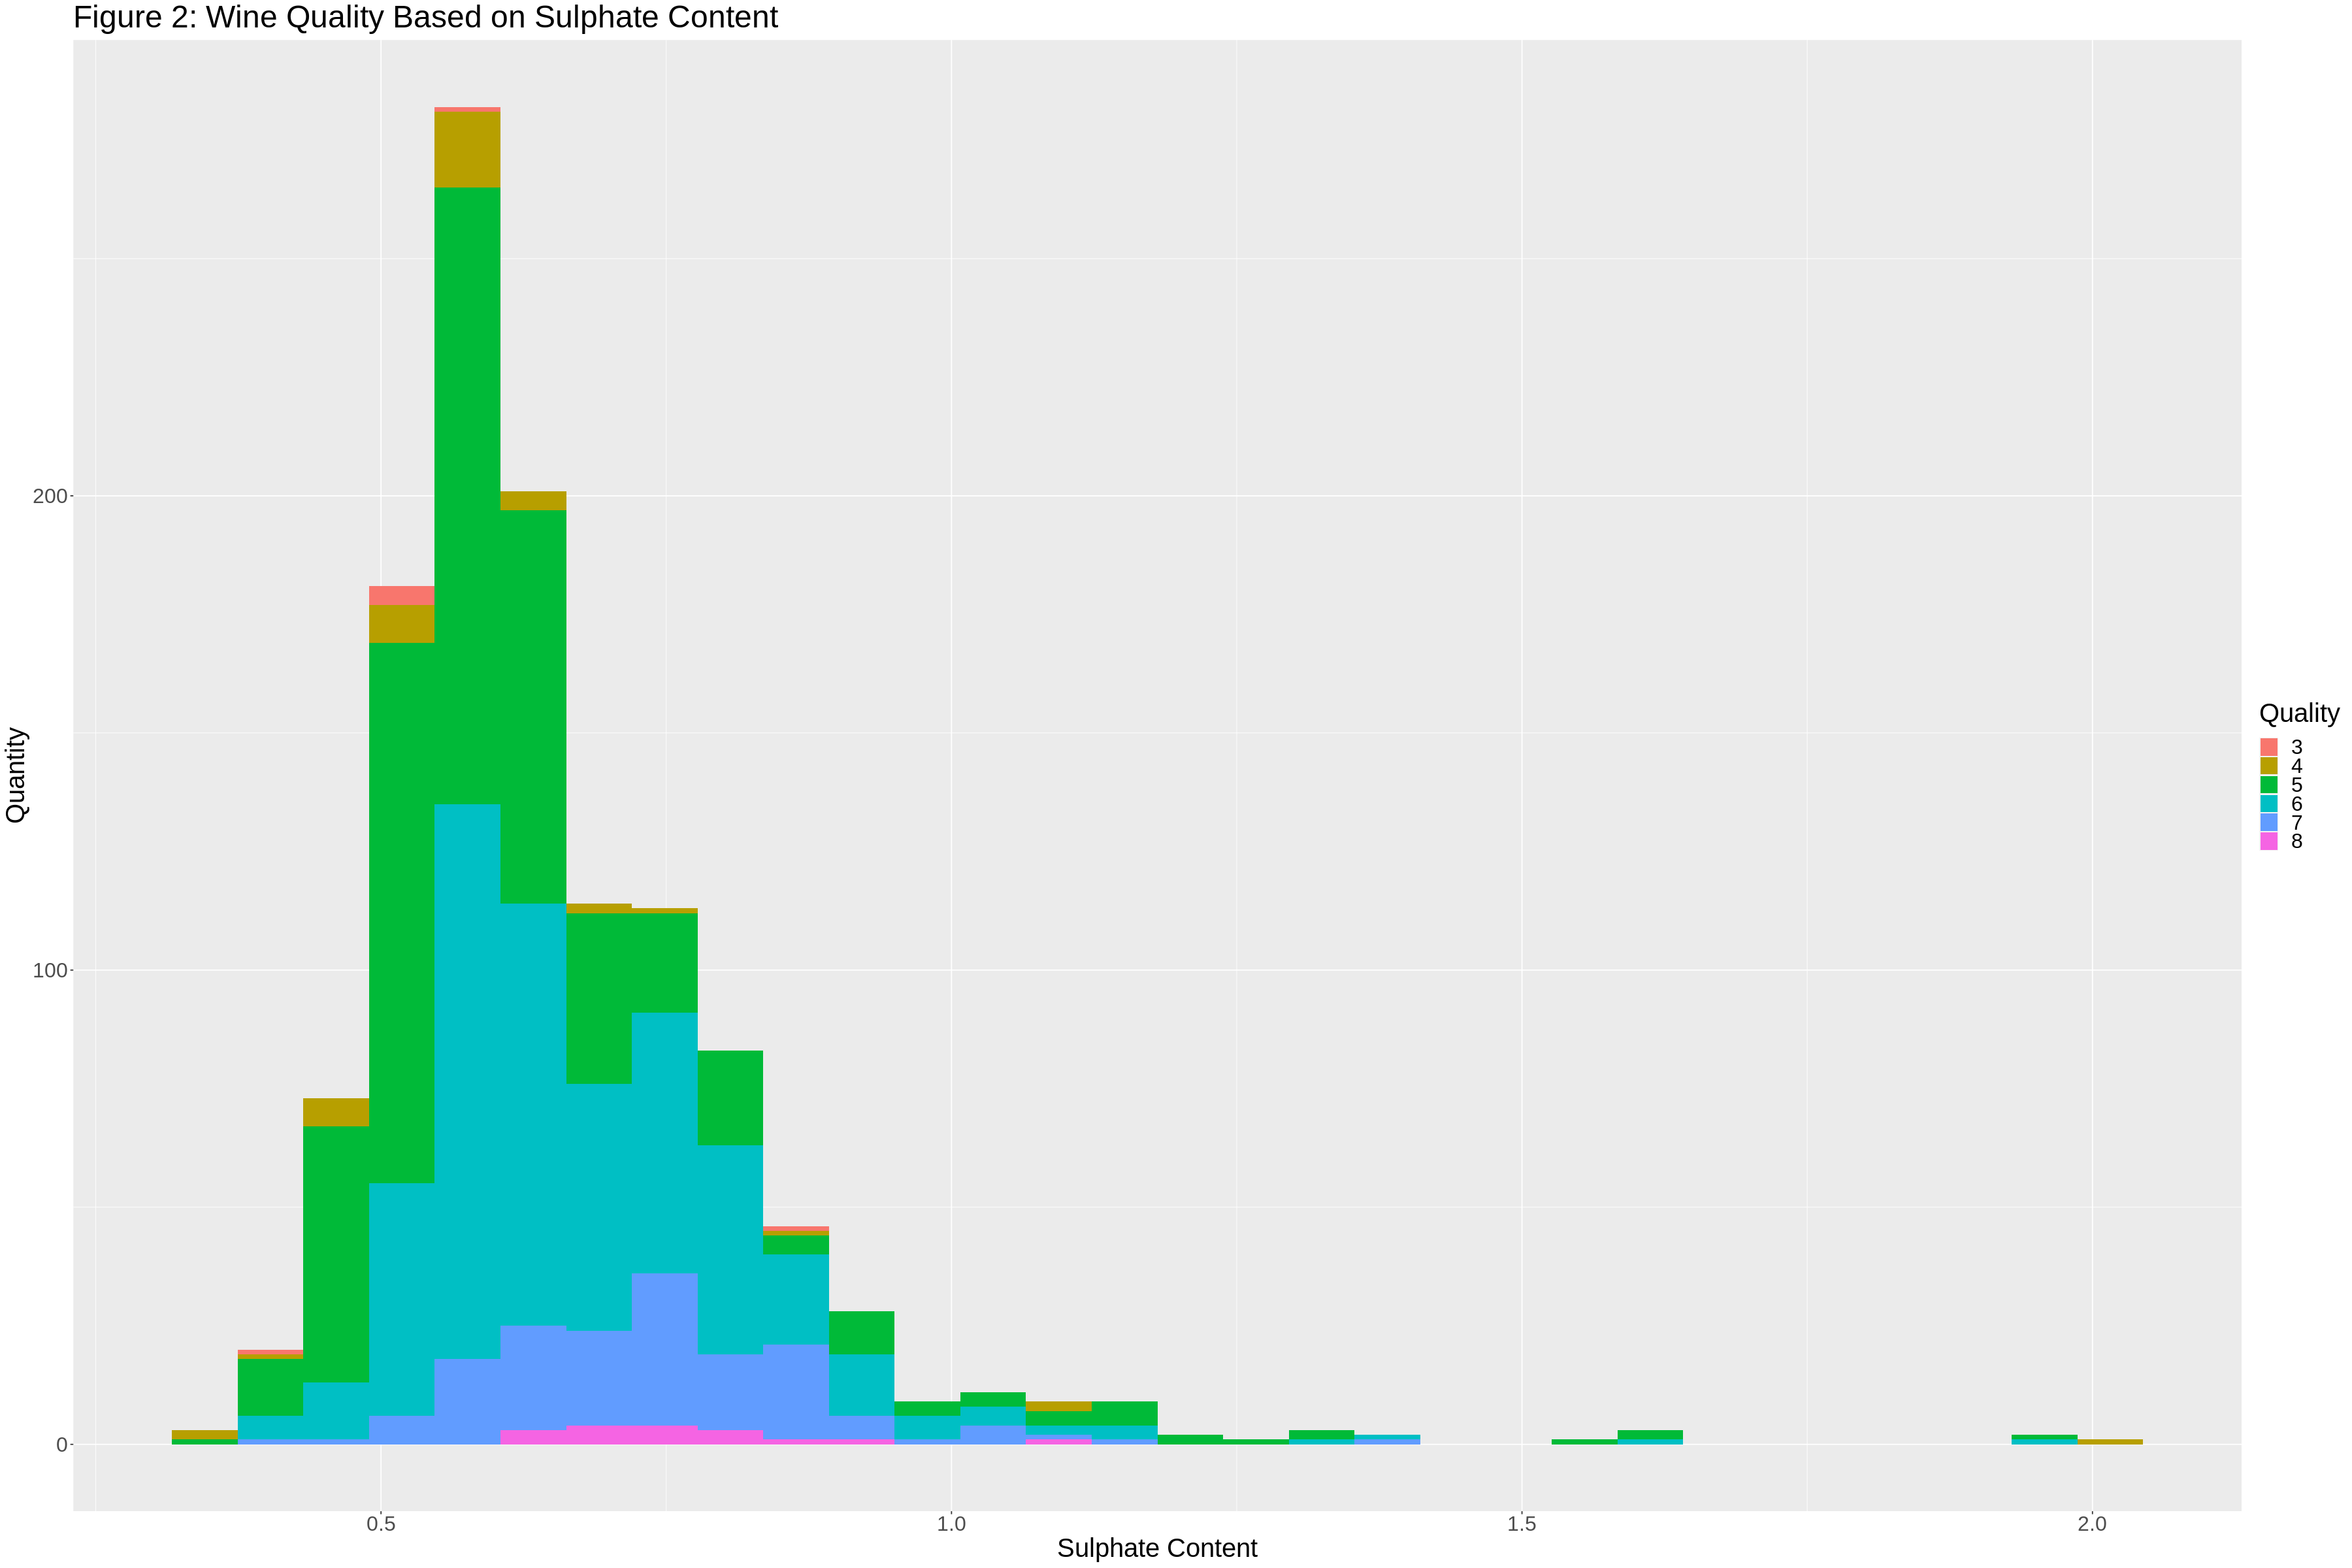

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



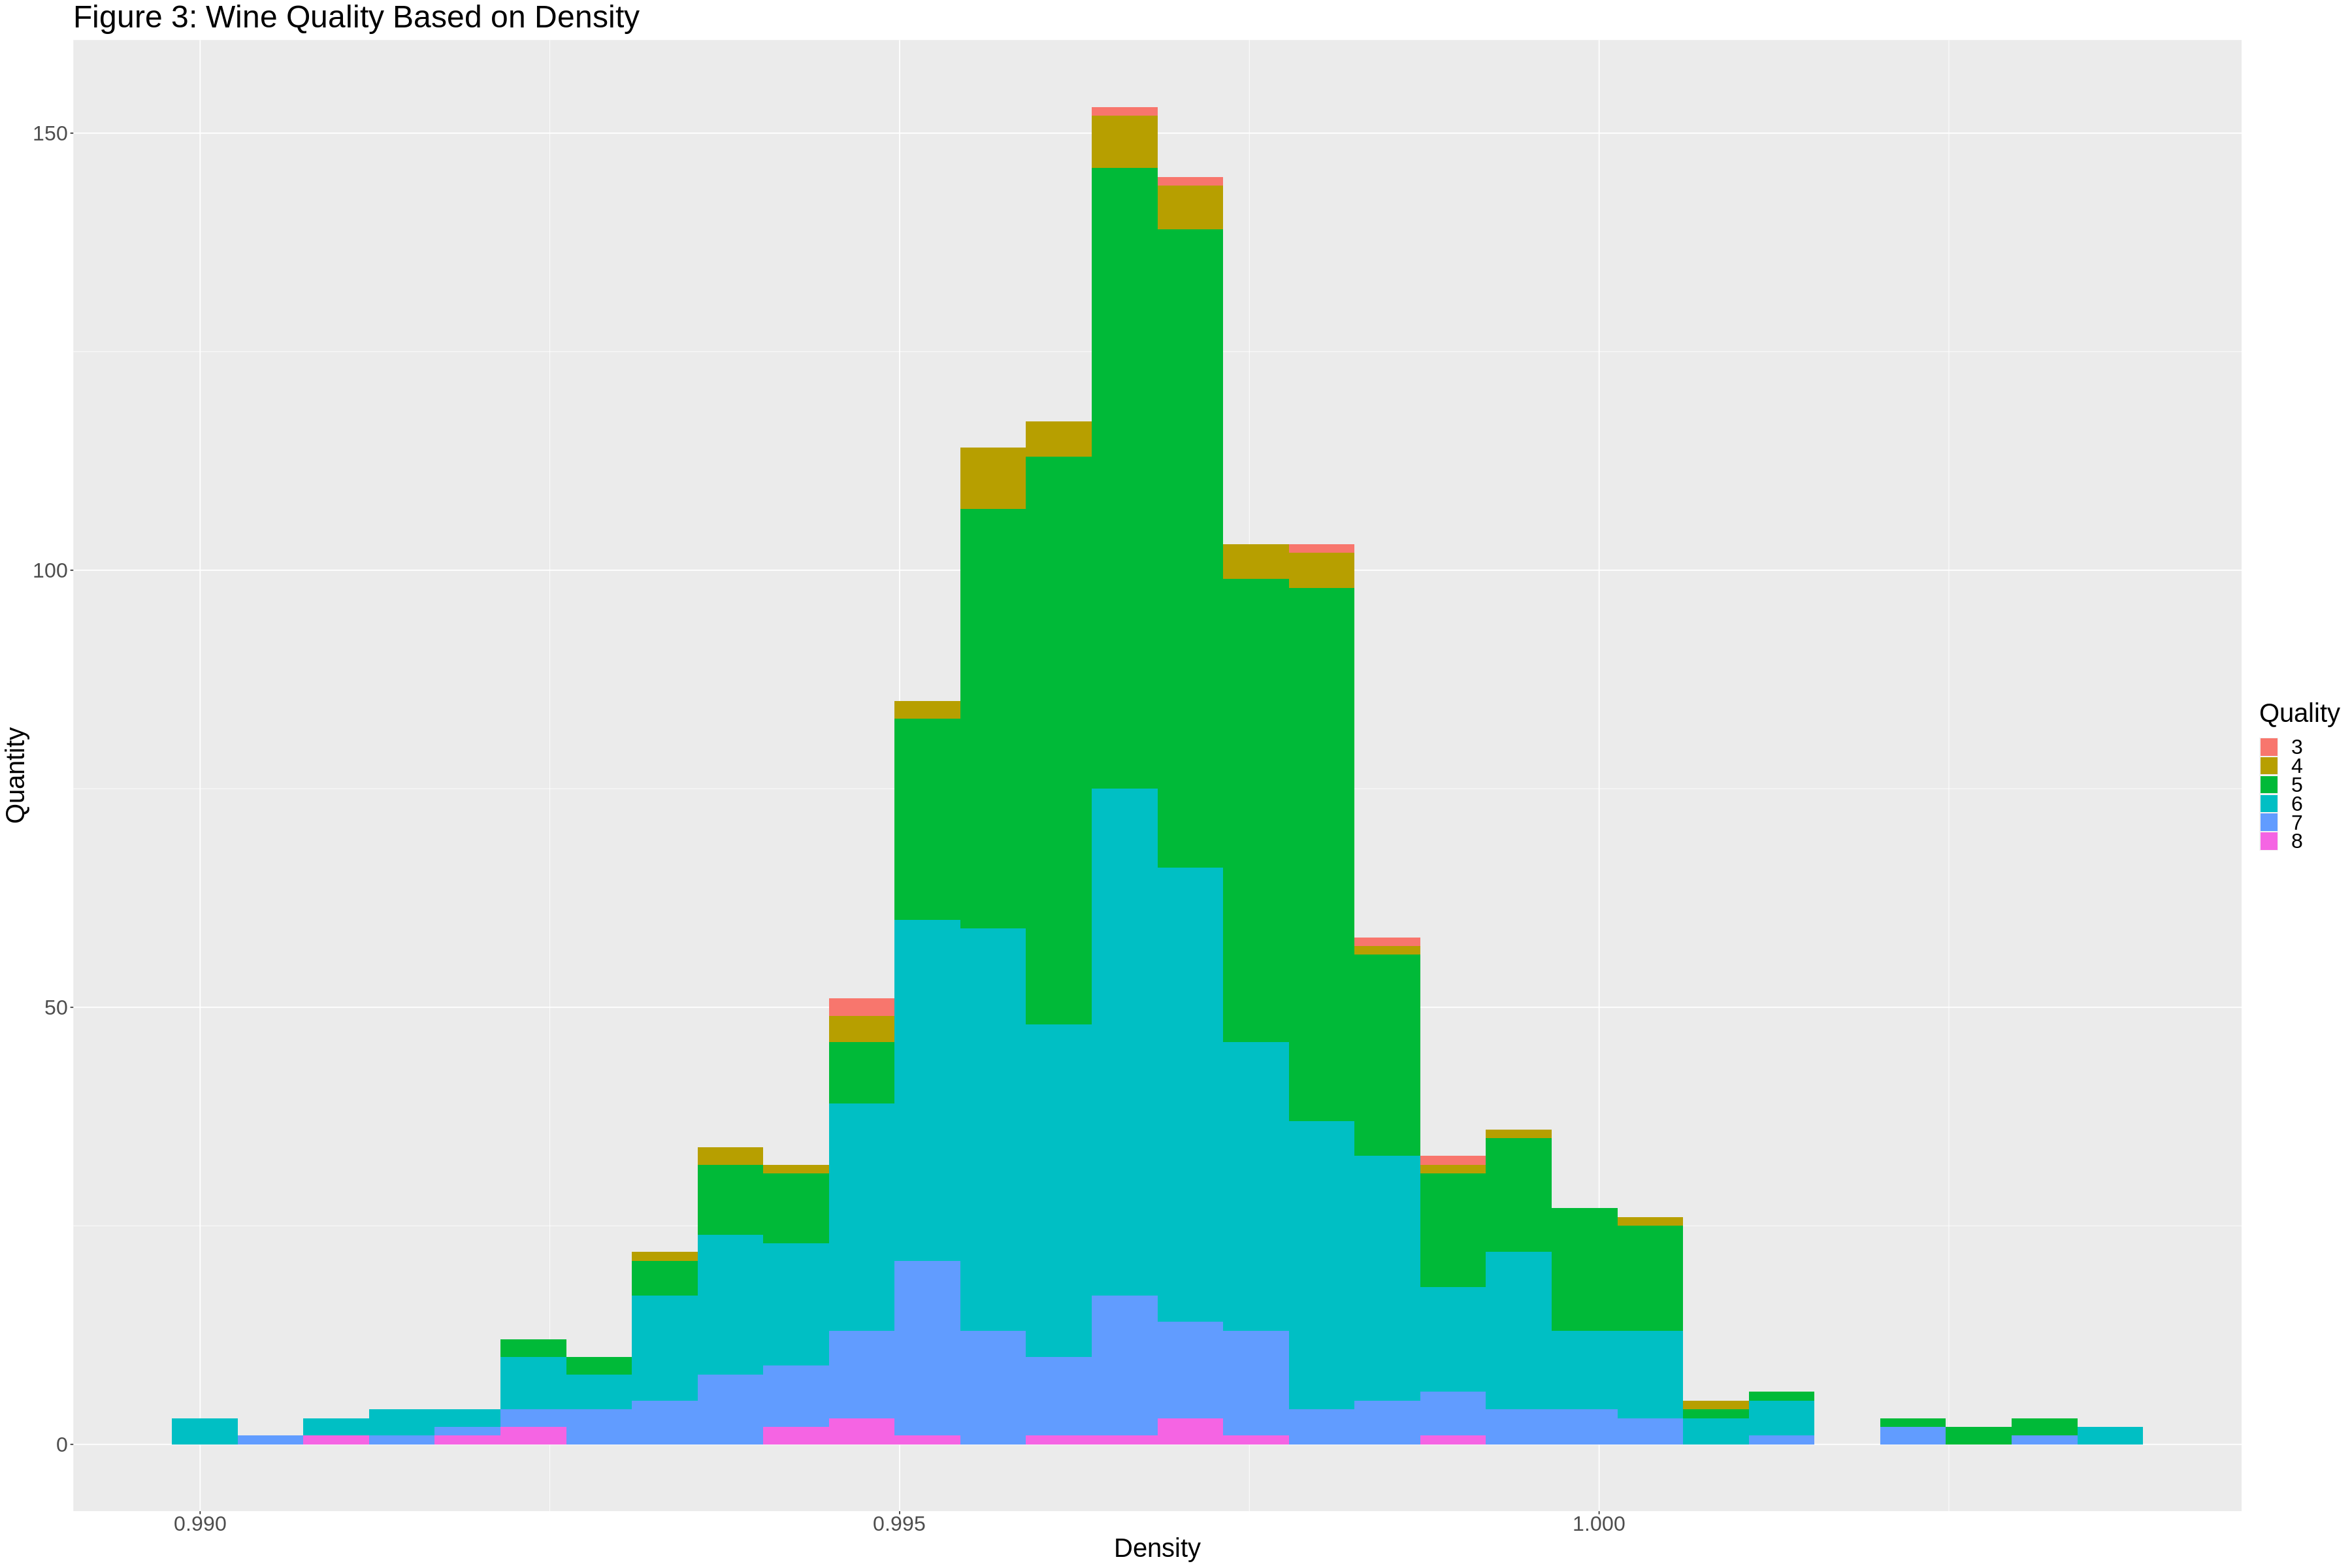

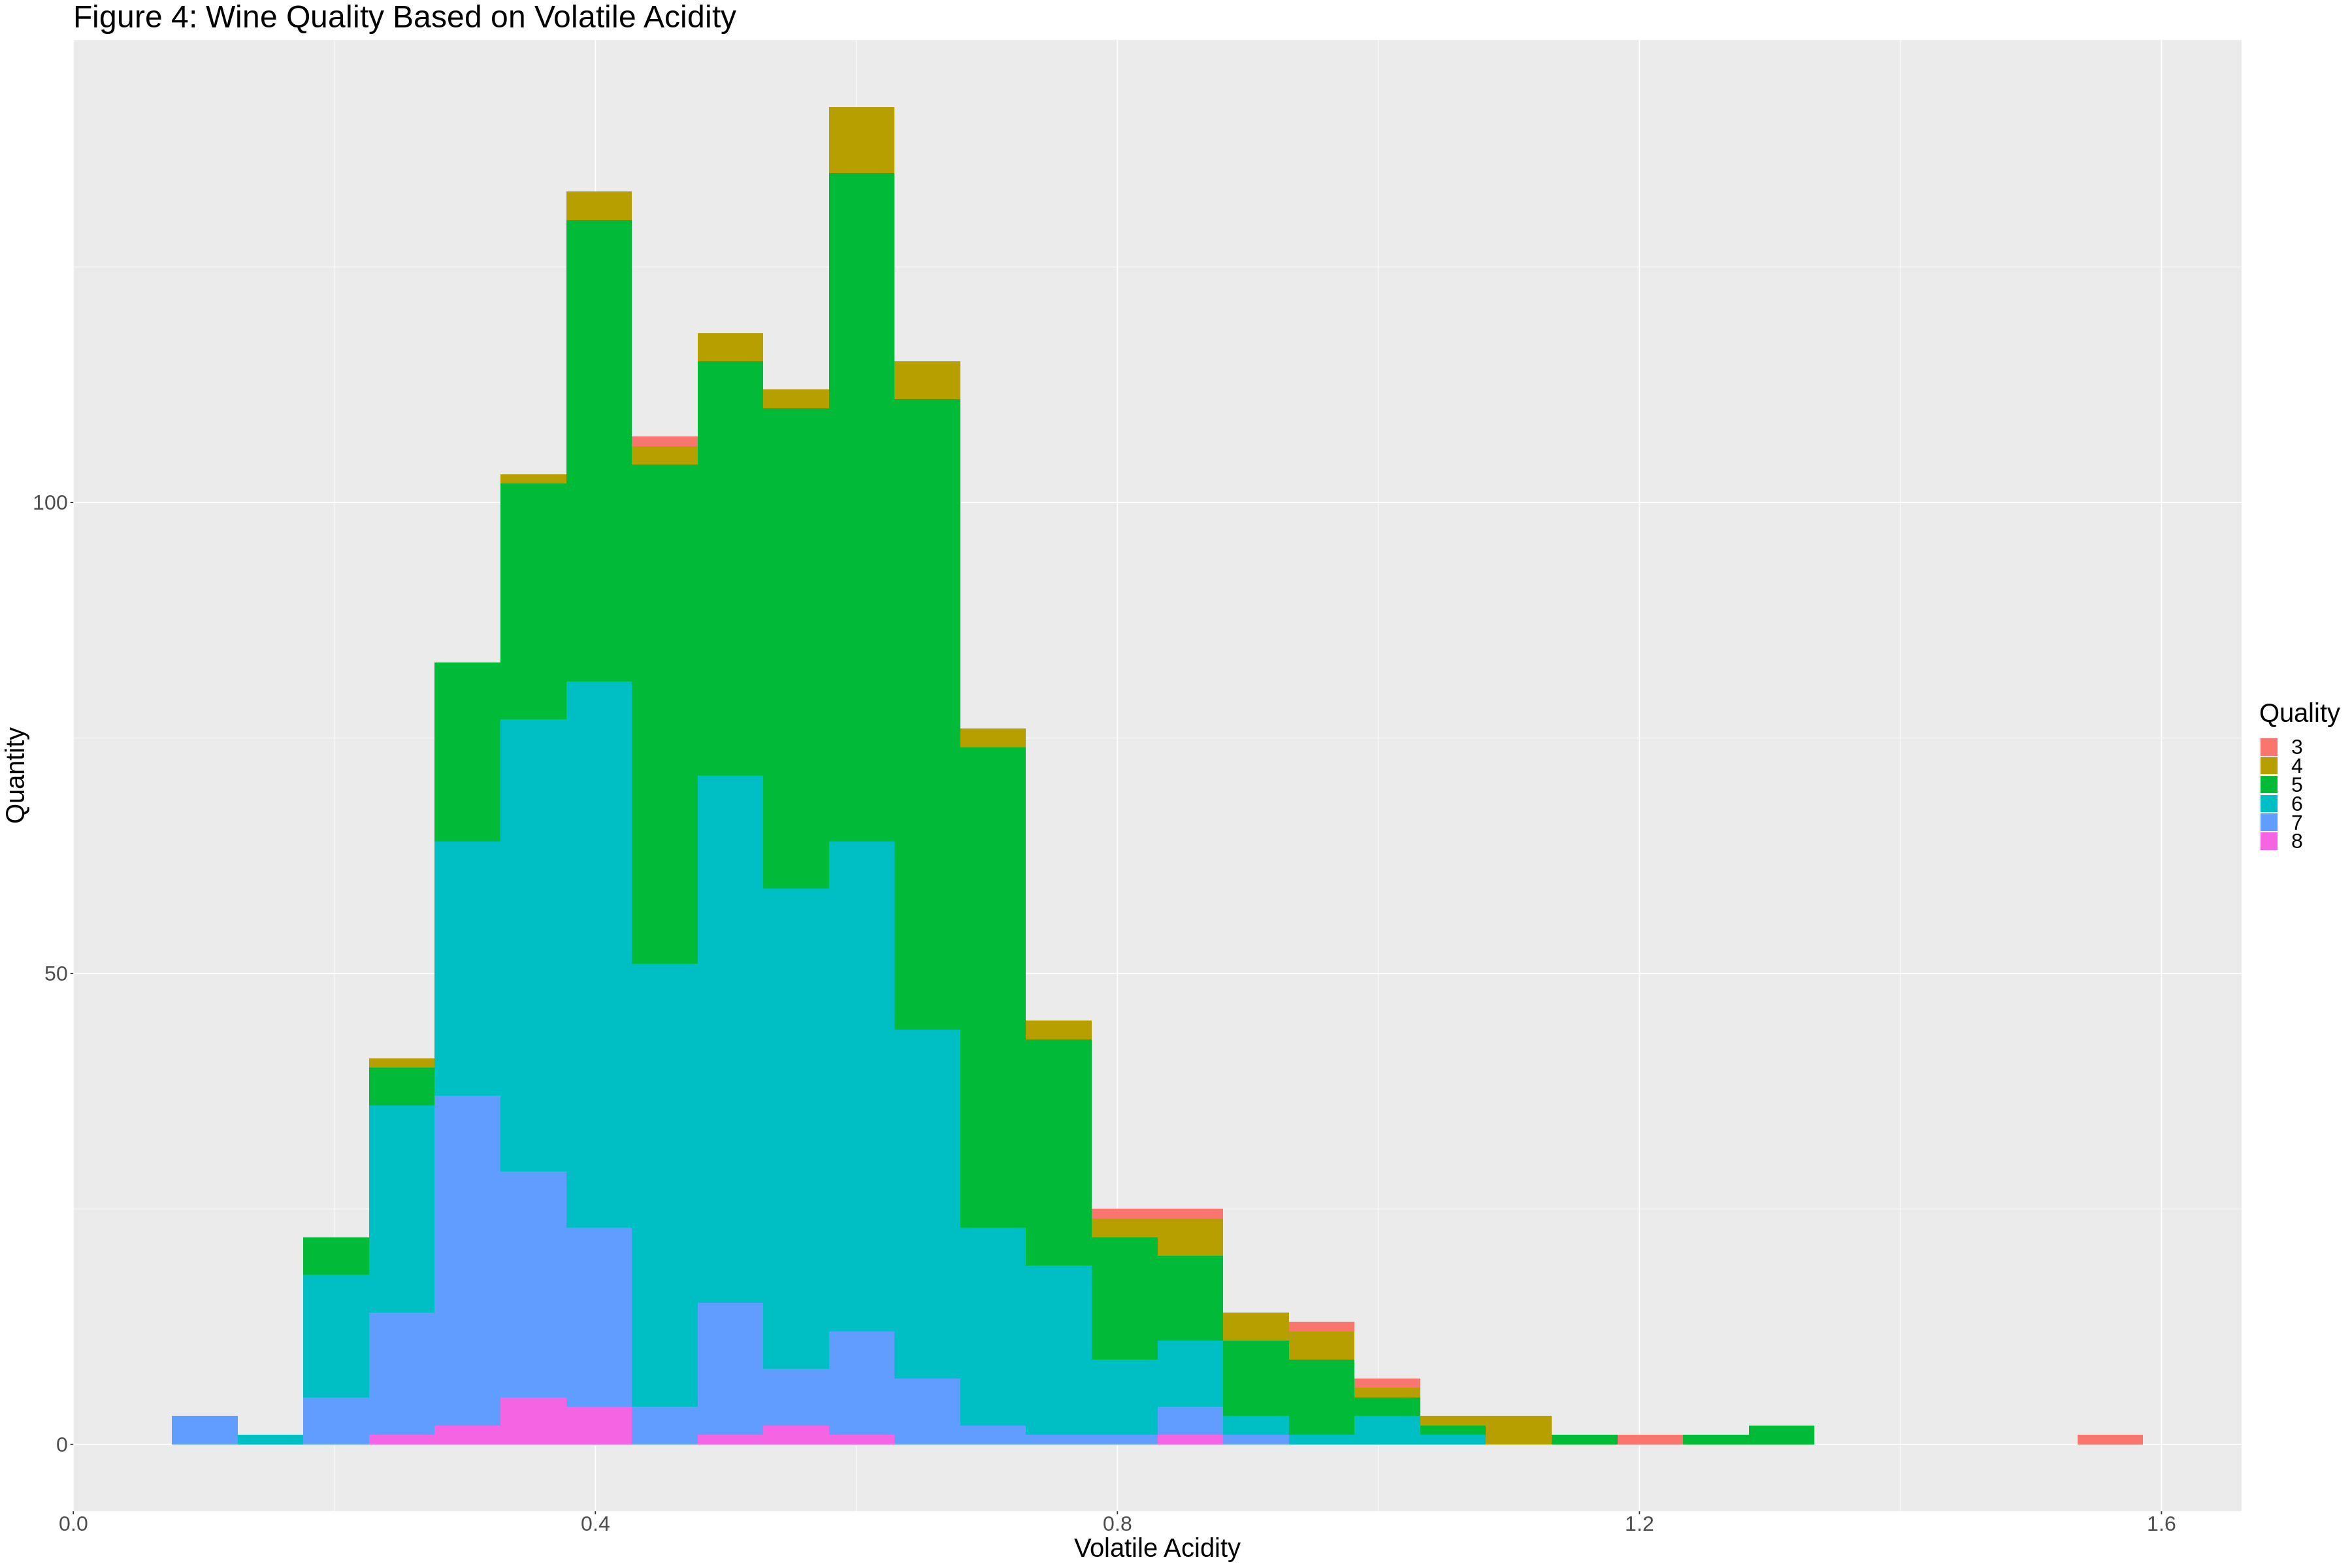

In [6]:
options(repr.plot.width = 30, repr.plot.height = 20)

#histogram of the number of wines for each quality
 count_plot <- ggplot(counts, aes(x=quality, y =n)) + geom_histogram(stat="identity") + ggtitle("Figure 1: Counts of all Ratings") + ylab("Quantity") +xlab("Quality Rating") + theme(text = element_text(size = 24)) 
count_plot

#histogram for wine quality based on sulphur content, sulphur on x axis, bars filled by quality rating, y axis = quantity
 sulphur_plot <- ggplot(red_train, aes(x=sulphates, fill=quality)) + geom_histogram() + xlab("Sulphate Content") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 2: Wine Quality Based on Sulphate Content") + theme(text = element_text(size = 24))
sulphur_plot

#histogram for wine quality based on density, density on x axis, bars filled by quality rating, y axis = quantity
density_plot <- ggplot(red_train, aes(x=density, fill=quality)) + geom_histogram() + xlab("Density") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 3: Wine Quality Based on Density") + theme(text = element_text(size = 24))
density_plot

#histogram for wine quality based on volatile acidity, volatile acidity on x axis, bars filled by quality rating, y axis = quantity
volatile_acidity_plot <- ggplot(red_train, aes(x=volatile.acidity, fill=quality)) + geom_histogram() + xlab("Volatile Acidity") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 4: Wine Quality Based on Volatile Acidity") + theme(text = element_text(size = 24))
volatile_acidity_plot



The above plots reveal many things to us:
- most wines have a quality rating of 5 or 6 out of 8 (Figure 1)
- most wines with a sulphate level between 0.5 and 1 have a quality rating of either 5 or 6. (Figure 2)
- most wines have a  density between 0.992 and 1.002 (Figure 3)
- most wines with volatile acidity between 0.25 and 0.8 have a quality rating of 5 or 6 (Figure 4)




**Methods**

Using the volatile acidity, sulphates and density values from the training data, we will build a predictive model that determines the quality rating for a given red wine. The model will use K-nn classification, using nearest neighbors for each variable. Cross validation on our model will be performed 10 times, and the number of neighbors in the model will be determined by setting "neighbors=tune()" to test values from 1 to 10. The K value with the highest training accuracy will be used to build the final K-nn classification model, which we will then apply to the testing data to predict quality ratings.


**Expected Outcomes**

Based on what we saw from the exploratory tables and visualizations, the model should predict wine quality with some degree of accuracy. It won't be perfect, but it should provide a reasonable estimate of a wine's quality. Human taste is ultimately the key aspect of determining whether a wine is high quality, but if quality is predicted by chemical properties alone, it could lead to breakthroughs in the winemaking industry. If successful, such a predictive model can have large implications in the industry, as the information could be used by winemakers to understand how they can produce higher quality wine, and rake in more profit. This could lead to the integration of modern chemical techniques and engineering with winemaking to revolutionize a craft that has been around for thousands of years.


**Analysis** 

We will now begin the construction of our predictive model. We will begine by creating a recipe, stating our predictors for use in the algorithm. To maximize accuracy of our classifier, we will be performing a 10-fold cross validation, and tuning our model to find the K value with the highest accuracy. Below, we build our model, selecting quality as what to predict, selecting volatile acidity, sulphates, and density as predictors, then scaling and centering them. 

! Fold01: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.

! Fold08: internal:
  No observations were detected in `truth` for level(s): '3'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5457010,10,0.011558479,Preprocessor1_Model01
2,accuracy,multiclass,0.5465277,10,0.011462146,Preprocessor1_Model02
3,accuracy,multiclass,0.5130327,10,0.017205731,Preprocessor1_Model03
4,accuracy,multiclass,0.4962888,10,0.017964860,Preprocessor1_Model04
5,accuracy,multiclass,0.5046149,10,0.014167207,Preprocessor1_Model05
6,accuracy,multiclass,0.5038297,10,0.016519499,Preprocessor1_Model06
7,accuracy,multiclass,0.5096914,10,0.012871902,Preprocessor1_Model07
8,accuracy,multiclass,0.5238524,10,0.010967535,Preprocessor1_Model08
9,accuracy,multiclass,0.5229846,10,0.009664199,Preprocessor1_Model09


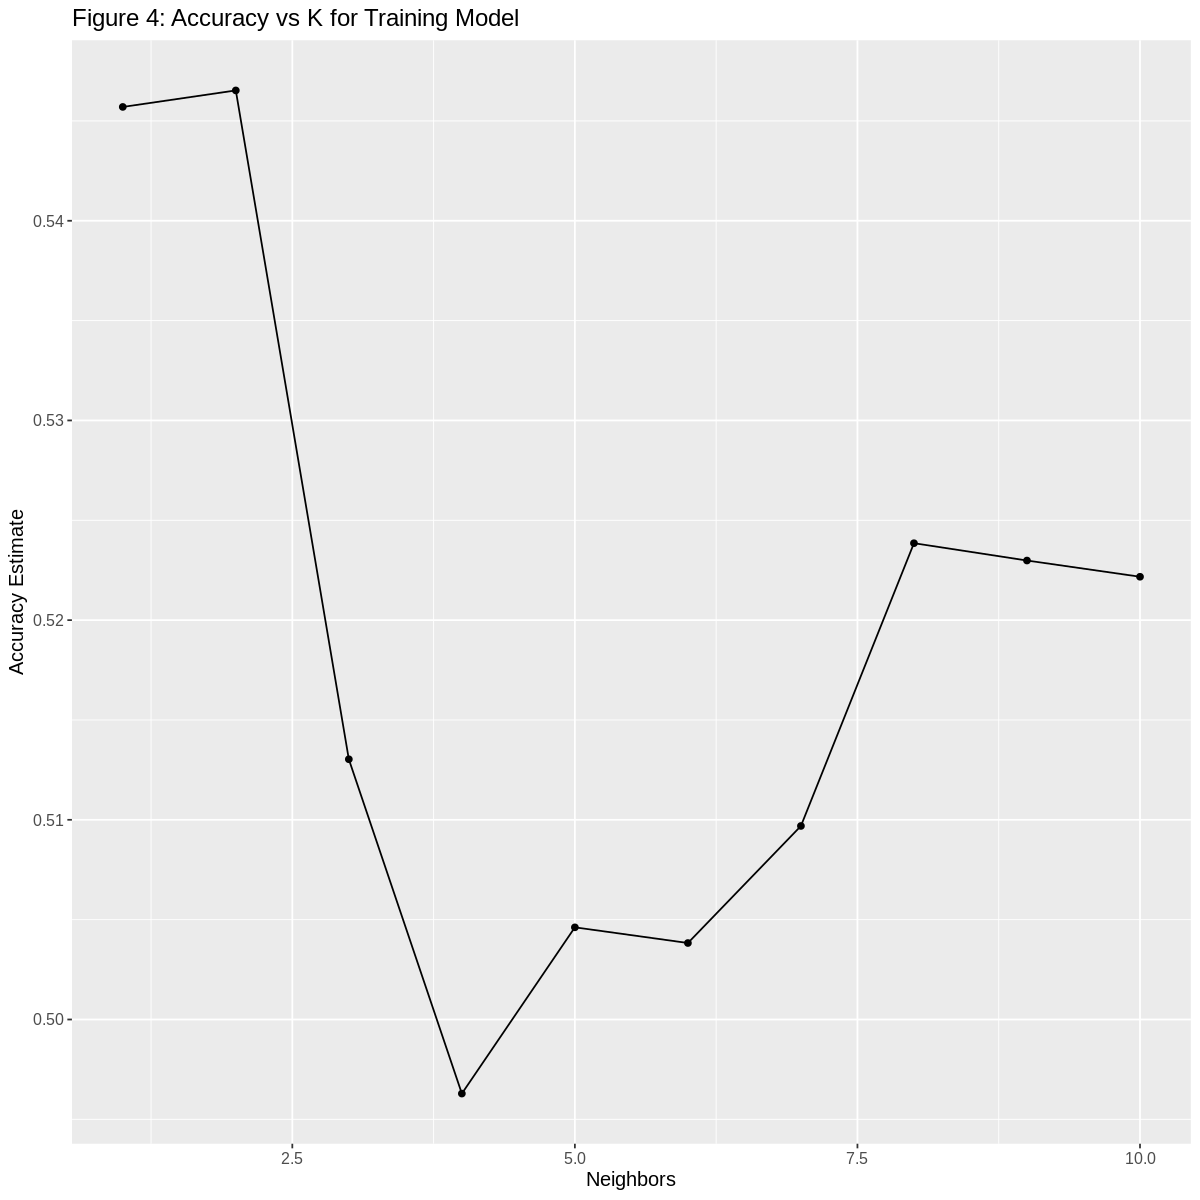

In [7]:
#specifying our 3 predictors and preprocessing the data to be centered and scaled
red_recipe<-recipe(quality~volatile.acidity+sulphates+citric.acid, data=red_train) |> step_scale(all_predictors()) |> step_center(all_predictors())

#splitting our overall training data into 10 evenly-sized chunks
red_vfold<-vfold_cv(red_train, v=10, strata=quality)

#creating a classifier in order to find the best K, the number of neighbors
knn_spec<-nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
                             set_engine("kknn") |>
                             set_mode("classification")

#using tune_grid in order to fit model for each value in a range of parameter values between 1 and 10
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
knn_results <- workflow() |>
  add_recipe(red_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = red_vfold, grid = k_vals) |>
  collect_metrics() 
#filtering for accuracy of each tested K value
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies
#creating a line plot using the accuracies dataset with neighbors on x-axis and mean on y-axis. This will help us pick the best K value

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + ggtitle("Figure 4: Accuracy vs K for Training Model")+ theme(text = element_text(size = 12))
options(repr.plot.width = 10, repr.plot.height = 10)
accuracy_vs_k


In [8]:

#creating a new classifier with the best K, the number of neighbors
knn_spec2 <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 2) |>
                             set_engine("kknn") |>
                             set_mode("classification")
#fitting the new classifier to our training data
knn_fit <- workflow() |>
       add_recipe(red_recipe) |>
       add_model(knn_spec2) |>
       fit(data = red_train)

#passing our fitted model to the testing data to make a prediction
prediction <- predict(knn_fit, red_test) |> bind_cols(red_test)

#finding our classifier's accuracy
prediction_accuracy <- prediction |>
       metrics(truth = quality, estimate = .pred_class)       
prediction_accuracy



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5621891
kap,multiclass,0.3138202


Looking at the accuracy of the qualifier, we see that it has a 56% prediction accuracy. This value represents only the predictions that were correct, and does not provide any information about the distribution of the predictions relative to the actual. To visualize the predictions for comparison with the actual quality ratings, we will create histograms for each variable and how it relates to either the predicted or actual quality value, shown by figures 5a-5f below.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



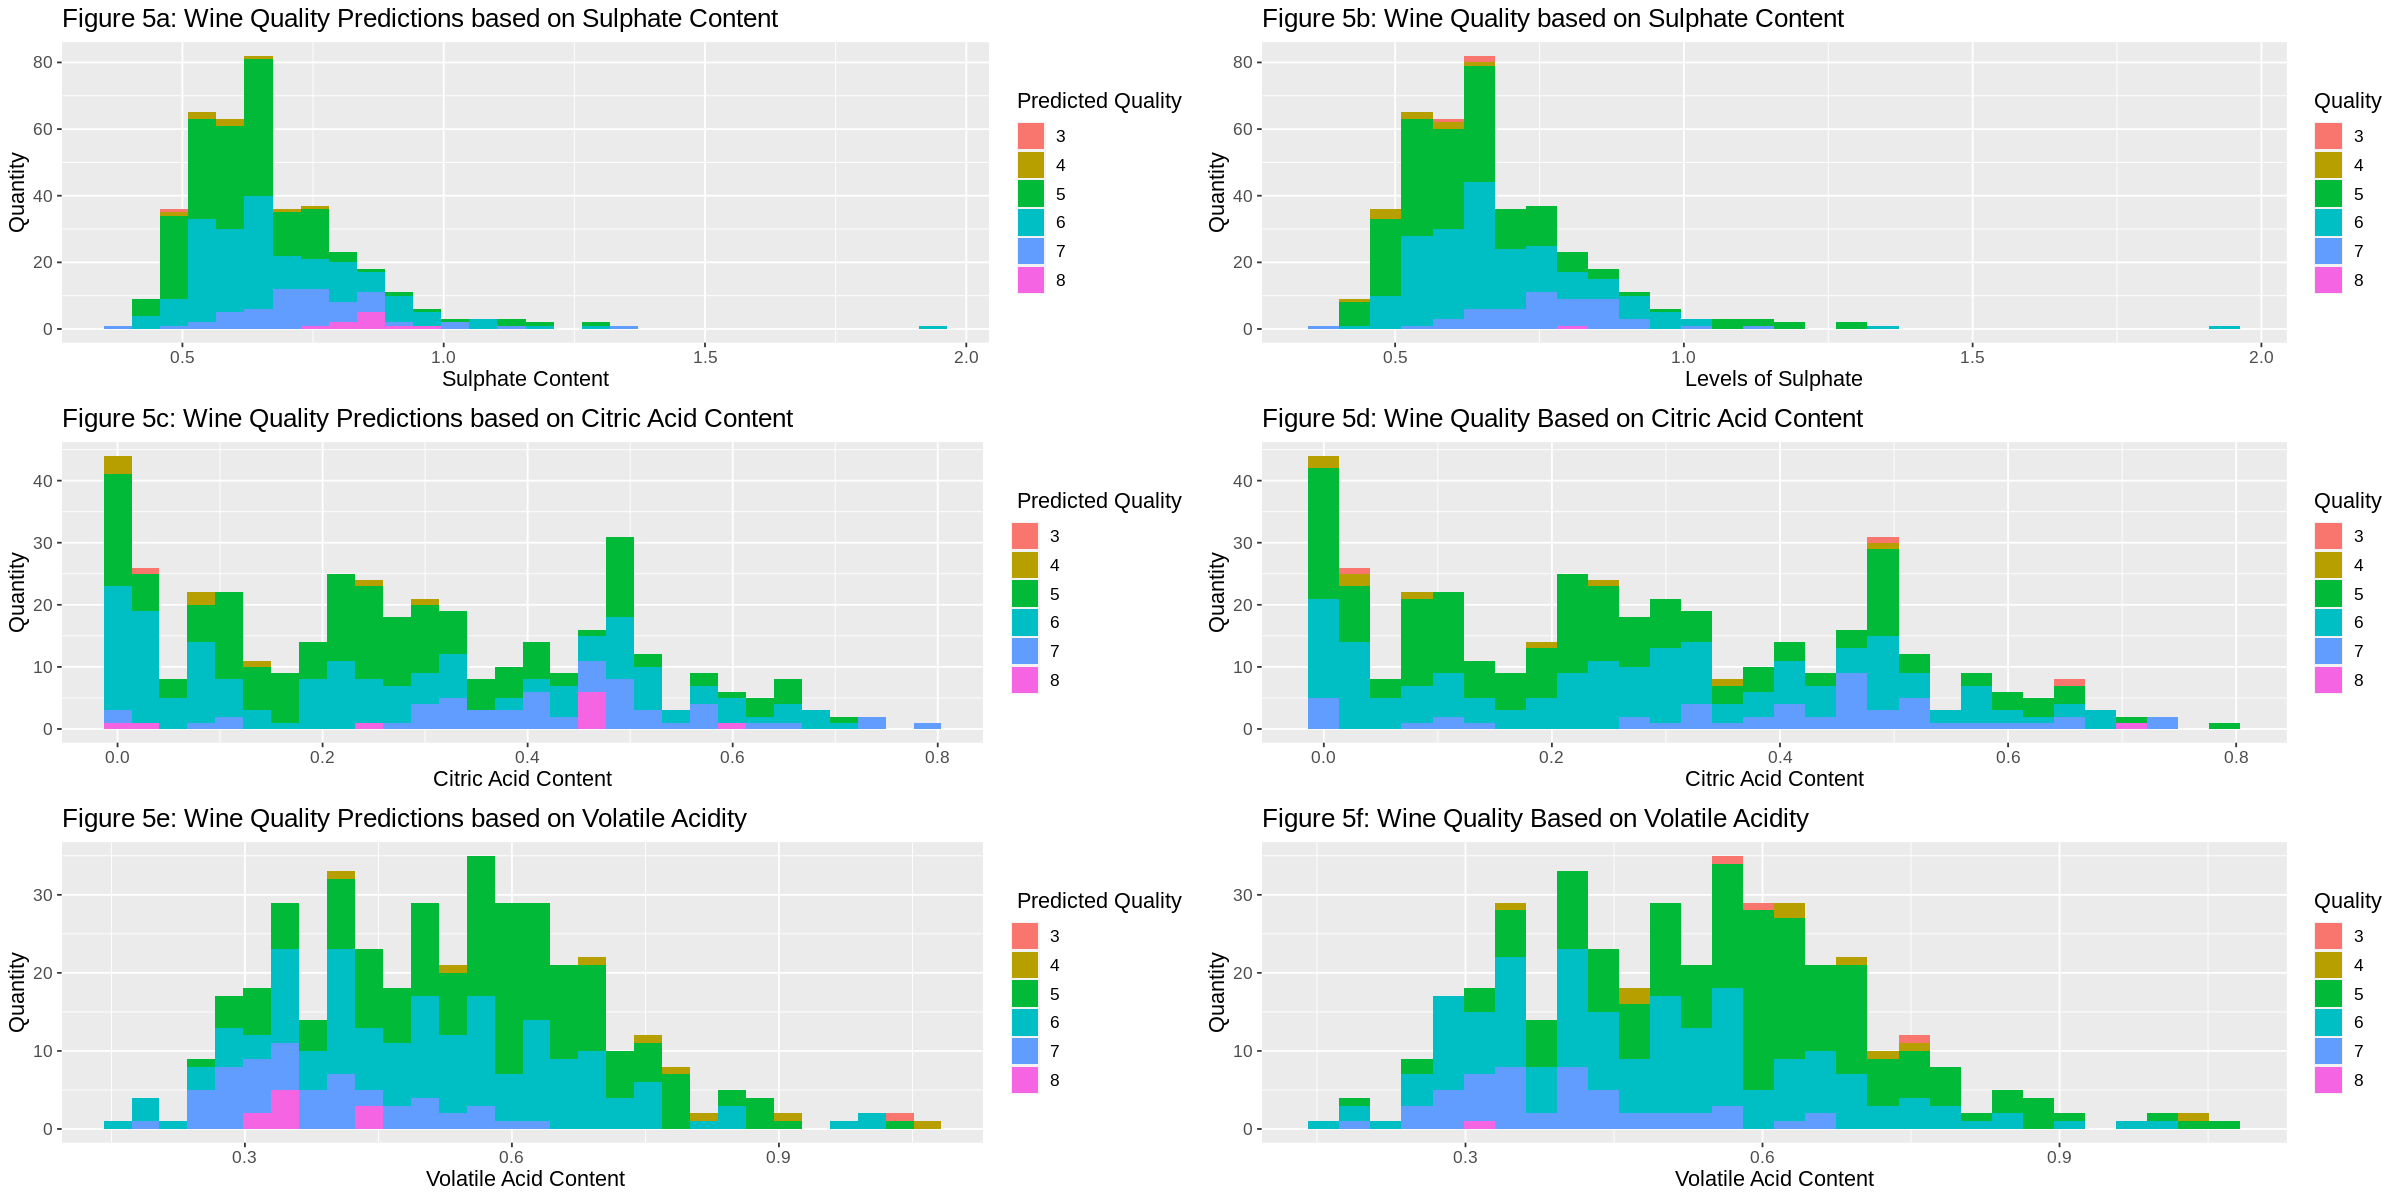

In [9]:

#comparing our predicted quality and the actual quality 
 sulphur_plot_pred <- ggplot(prediction, aes(x=sulphates, fill=.pred_class)) + geom_histogram() + xlab("Sulphate Content") + 
ylab("Quantity") +labs(fill="Predicted Quality") + ggtitle("Figure 5a: Wine Quality Predictions based on Sulphate Content") + theme(text = element_text(size = 13))

sulphur_plot_actual <- ggplot(prediction, aes(x=sulphates, fill=quality)) + geom_histogram() + xlab("Levels of Sulphate") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 5b: Wine Quality based on Sulphate Content") + theme(text = element_text(size = 13))

density_plot_pred<- ggplot(prediction, aes(x=citric.acid, fill=.pred_class)) + geom_histogram() + xlab("Citric Acid Content") + 
ylab("Quantity") +labs(fill=" Predicted Quality") + ggtitle("Figure 5c: Wine Quality Predictions based on Citric Acid Content") + theme(text = element_text(size = 13))

density_plot_actual<- ggplot(prediction, aes(x=citric.acid, fill=quality)) + geom_histogram() + xlab("Citric Acid Content") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 5d: Wine Quality Based on Citric Acid Content") + theme(text = element_text(size = 13))

acidity_plot_pred<- ggplot(prediction, aes(x=volatile.acidity, fill=.pred_class)) + geom_histogram() + xlab(" Volatile Acid Content") + 
ylab("Quantity") +labs(fill=" Predicted Quality") + ggtitle("Figure 5e: Wine Quality Predictions based on Volatile Acidity") + theme(text = element_text(size = 13))

acidity_plot_actual<- ggplot(prediction, aes(x=volatile.acidity, fill=quality)) + geom_histogram() + xlab("Volatile Acid Content") + 
ylab("Quantity") +labs(fill="Quality") + ggtitle("Figure 5f: Wine Quality Based on Volatile Acidity") + theme(text = element_text(size = 13))


options(repr.plot.width = 20, repr.plot.height = 10)
plot_grid(sulphur_plot_pred, sulphur_plot_actual, density_plot_pred, density_plot_actual,acidity_plot_pred, acidity_plot_actual, ncol = 2)

**Discussion**

Looking at the visualizations from our classifier output provides much more insight than the percent accuracy value. Looking at figures 5a and 5b, the overall shape and distribution of quality seems quite similar. The main noticeable difference being the spike of wines at 0.75 acidity with a predicted quality of 7 actually have a quality rating of 6. So while the classifier gave an incorrect prediction, the predictions were not far off. This pattern is seen in all of the other graphs as well. Comparing the prediction graphs in the left column with the graphs with the actual quality shown by the graphs in the right column, the graphs take oon similar shapes, and most of the differences vary by 1 quality point. In a small number of cases where true quality is at the extremes of the scale (a 3 or an 8) the predictive model may have given it a rating 2 points away from its actual (seen in figure 5e and 5f). This provides some more context behind the predictive ability of our classifier, showing that while the quality rating was predicted perfectly 62% of the time, a majority of the incorrect predictions were only 1 point away from the true value.

With this infirmation in mind, it seems like the classification model is able to make a fairly accurate prediction about the quality of a certain wine. Such a classifier could be of great use to winemakers, allowing them to see wine quality by taking measurements during the winemaking process. Based on the information produced by the classifier, winemakers may then make decisions about how they cal alter the winemaking process to produce higher quality wine.